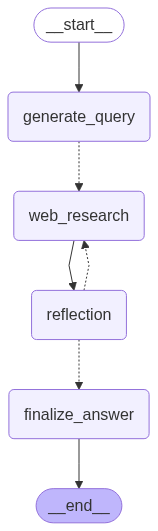

In [1]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from rich import print as rprint
import os
from openai import Client
from langgraph.types import Send
from langchain_openai import ChatOpenAI
from configuration import Configuration
from langchain.chat_models import init_chat_model
from langgraph.prebuilt import create_react_agent
from prompts import (
    get_current_date,
    query_writer_instructions,
    web_searcher_instructions,
    reflection_instructions,
    answer_instructions
)
from state import (
    OverallState,
    QueryGenerationState,
    ReflectionState,
    WebSearchState
)
from langchain_core.runnables.config import RunnableConfig
from dotenv import load_dotenv

from tools_and_schemas import (
    SearchQueryList,
    search_tool,
    Reflection
)
from utils import (
    get_citations,
    get_research_topic,
    insert_citation_markers,
    resolve_urls
)
load_dotenv()


def generate_query(state: OverallState, config: RunnableConfig) -> QueryGenerationState:
    """LangGraph node that generates search queries based on the User's question.

    Uses OpenAI chatgpt to create an optimized search queries for web research based on
    the User's question.

    Args:
        state: Current graph state containing the User's question
        config: Configuration for the runnable, including LLM provider settings

    Returns:
        Dictionary with state update, including search_query key containing the generated queries
    """
    configurable = Configuration.from_runnable_config(config)

    if state.get("initial_search_query_count") is None:
        state["initial_search_query_count"] = configurable.number_of_initial_queries

    llm = init_chat_model(
        model=configurable.query_generator_model,
        model_provider="openai",
        temperature=1.0,
        max_retries=2
    )

    structured_llm = llm.with_structured_output(SearchQueryList)

    current_date = get_current_date()
    formatted_prompt = query_writer_instructions.format(
        current_data=current_date,
        research_topic=get_research_topic(state["messages"]),
        number_queries=state["initial_search_query_count"]
    )
    result = structured_llm.invoke(formatted_prompt)
    return {"search_query": result.query}


def continue_to_web_research(state: QueryGenerationState):
    """LangGraph node that sends the search queries to the web research node.

    This is used to spawn n number of web research nodes, one for each search query.
    """
    return [
        Send("web_search", {"search_query": search_query, "id": int(idx)})
        for idx, search_query in enumerate(state["search_query"])
    ]


def web_research(state: WebSearchState, config: RunnableConfig) -> OverallState:
    """LangGraph node that performs web research using the native Google Search API tool.

    Executes a web search using the native Google Search API tool in combination with Gemini 2.0 Flash.

    Args:
        state: Current graph state containing the search query and research loop count
        config: Configuration for the runnable, including search API settings

    Returns:
        Dictionary with state update, including sources_gathered, research_loop_count, and web_research_results
    """
    configurable = Configuration.from_runnable_config(config)
    formatted_prompt = web_searcher_instructions.format(
        current_date=get_current_date(),
        research_topic=state["search_query"]
    )

    model = init_chat_model(
        model=configurable.query_generator_model,
        model_provider="openai"
    )
    web_agent = create_react_agent(
        model=model,
        tools=[search_tool]
    )
    response = web_agent.invoke(
        {"messages": [SystemMessage(content=formatted_prompt)]})
    resolved_urls = resolve_urls(
        response["messages"][-1].content,
        state["id"]
    )

    citations = get_citations(response, resolved_urls)
    modified_text = insert_citation_markers(response.text, citations)
    sources_gathered = [
        item for citation in citations for item in citation["segments"]]

    return {
        "sources_gathered": sources_gathered,
        "search_query": [state["search_query"]],
        "web_research_result": [modified_text]
    }


def reflection(state: OverallState, config: RunnableConfig) -> ReflectionState:
    """LangGraph node that identifies knowledge gaps and generates potential follow-up queries.

    Analyzes the current summary to identify areas for further research and generates
    potential follow-up queries. Uses structured output to extract
    the follow-up query in JSON format.

    Args:
        state: Current graph state containing the running summary and research topic
        config: Configuration for the runnable, including LLM provider settings

    Returns:
        Dictionary with state update, including search_query key containing the generated follow-up query
    """

    configurable = Configuration.from_runnable_config(config)
    state["research_loop_count"] = state.get("research_loop_count", 0) + 1
    reasoning_model = state.get(
        "reasoning_model", configurable.reflection_model)

    current_date = get_current_date()
    formatted_prompt = reflection_instructions.format(
        current_date=current_date,
        research_topic=get_research_topic(state["messages"]),
        summaries="\n\n--\n\n".join(state["web_research_result"])
    )

    llm = ChatOpenAI(
        model=reasoning_model,
        temperature=1.0,
        max_retries=2,
    )
    result: Reflection = llm.with_structured_output(
        Reflection).invoke(formatted_prompt)
    return {
        "is_sufficient": result.is_sufficient,
        "knowledge_gap": result.knowledge_map,
        "follow_up_queries": result.follow_up_queries,
        "research_loop_count": state["research_loop_count"],
        "number_of_ran_queries": len(state["search_query"])
    }


def evaluate_research(
    state: ReflectionState,
    config: RunnableConfig
) -> OverallState:
    """LangGraph routing function that determines the next step in the research flow.

    Controls the research loop by deciding whether to continue gathering information
    or to finalize the summary based on the configured maximum number of research loops.

    Args:
        state: Current graph state containing the research loop count
        config: Configuration for the runnable, including max_research_loops setting

    Returns:
        String literal indicating the next node to visit ("web_research" or "finalize_summary")
    """
    configurable = Configuration.from_runnable_config(config)
    max_research_loops = (
        state.get("max_research_loops")
        if state.get("max_research_loops") is not None
        else configurable.max_research_loops
    )
    if state["is_sufficient"] or state["research_loop_count"] >= max_research_loops:
        return "finalize_answer"
    else:
        return [
            Send(
                "web_research",
                {
                    "search_query": follow_up_query,
                    "id": state["number_of_ran_queries"] + int(idx)
                },
            )
            for idx, follow_up_query in enumerate(state["follow_up_queries"])
        ]


def finalize_answer(state: OverallState, config: RunnableConfig):
    """LangGraph node that finalizes the research summary.

    Prepares the final output by deduplicating and formatting sources, then
    combining them with the running summary to create a well-structured
    research report with proper citations.

    Args:
        state: Current graph state containing the running summary and sources gathered

    Returns:
        Dictionary with state update, including running_summary key containing the formatted final summary with sources
    """
    configurable = Configuration.from_runnable_config(config)
    reasoning_model = state.get("reasoning_model") or configurable.answer_model

    current_date = get_current_date()
    formatted_prompt = answer_instructions.format(
        current_date=current_date,
        research_topic=get_research_topic(state["messages"]),
        summaries="\n--\n\n".join(state["web_research_result"])
    )

    llm = ChatOpenAI(
        model=reasoning_model,
        temperature=0,
        max_retries=2,
    )
    result = llm.invoke(formatted_prompt)

    unique_sources = []
    for source in state["sources_gathered"]:
        if source["short_url"] in result.content:
            result.content = result.content.replace(
                source["short_url"], source["values"]
            )
            unique_sources.append(source)
    return {
        "messages": [AIMessage(content=result.content)],
        "sources_gathered": unique_sources
    }


builder = StateGraph(OverallState, config_schema=Configuration)

builder.add_node("generate_query", generate_query)
builder.add_node("web_research", web_research)
builder.add_node("reflection", reflection)
builder.add_node("finalize_answer", finalize_answer)

builder.add_edge(START, "generate_query")
builder.add_conditional_edges(
    "generate_query", continue_to_web_research, ["web_research"]
)
builder.add_edge("web_research", "reflection")
builder.add_conditional_edges(
    "reflection", evaluate_research, ["web_research", "finalize_answer"]
)
builder.add_edge("finalize_answer", END)

graph = builder.compile(name="pro-search-agent")

display(Image(graph.get_graph().draw_mermaid_png()))
